In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt #get_ipython().run_line_magic('matplotlib', 'inline')
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import json
import csv

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.
/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/404/404/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/404/404/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/404/404/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [2]:
ROOT_DIR = "/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/"
IMAGE_EMBEDDING_DIR = ROOT_DIR#+"imageGroupsOutput/"
IMAGE_EMBEDDING_VAL_DIR = ROOT_DIR
GLOVE_EMBEDDING_FILE_NAME = ROOT_DIR+'glove.6B.300d.txt'
TEST_IMAGE_DIR = ROOT_DIR + "images/train/images/train/"
GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.50d.txt'
CAPTION_FILE_NAME = ROOT_DIR+'image_to_caption.csv'
weight_filepath = ROOT_DIR+'weights/model-ep{epoch:03d}-loss{loss:.3f}.h5'

SEED = 10
NUM_IMAGE_EMBEDDING_CHUNKS = 1
MAX_SEQUENCE_LENGTH = 12
WORD_EMBEDDING_DIM = 50
BATCH_SIZE = 32

In [3]:
def getCaptions(id_list):
    caption_dict = {}
    with open(CAPTION_FILE_NAME) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if row[1] in id_list:
                caption_dict[row[1]] = row[2]
    return caption_dict

In [4]:
def vocab_fun(captions):
    index_to_word = {}
    word_to_index = {}
    all_words = {}
    all_words['startseq'] = 1
    all_words['endseq'] = 1
    for img_id, cap in captions.items():
        for word in cap.split():
            all_words[word] = 1    
    all_vocab=[w for w in all_words]
    index = 1
    for word in all_vocab:
        word_to_index[word] = index
        index_to_word[index] = word
        index += 1
    return (all_vocab, word_to_index, index_to_word)

In [5]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

def getImageEmbedding(path):
    image_embedding = {}
    for i in range(NUM_IMAGE_EMBEDDING_CHUNKS):
        file_name = path + 'cnn_group'+str(i+1)+'.json'
        with open(file_name) as json_file:
            json_data = json.load(json_file)
            json_data = json.loads(json_data)
            image_embedding = Merge(image_embedding, json_data) 
    print(len(image_embedding))
    return image_embedding

In [6]:
# def data_generator(descriptions, photos, wordtoix, vocab_size): #descriptions are captions
#     X1, X2, y = list(), list(), list()
    
#     for key, desc in descriptions.items():
            
#         desc_in = "startsqe" + desc
#         desc_out = desc+ " endseq"

#         seq_in = [wordtoix[word] for word in desc_in.split() if word in wordtoix]
#         seq_in = pad_sequences([seq_in], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')[0]
#         print(seq_in)
#         seq_out = [wordtoix[word] for word in desc_out.split() if word in wordtoix]
#         seq_out = pad_sequences([seq_out], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')[0]

#         if len(seq_out) > MAX_SEQUENCE_LENGTH:
#             seq_out[-1]=wordtoix['endseq']
#         print(seq_out)
#         X1.append(photos[key])
#         X2.append(seq_in)
#         y.append(keras.utils.to_categorical(seq_out, num_classes=vocab_size))
#     return (array(X1), array(X2), array(y))

In [36]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, image_embedding, captions, batch_size=32, num_caption=12, image_dim= 2048, shuffle=True, vocab_size = 5000):
        'Initialization'
        self.image_dim = image_dim
        self.num_caption = num_caption
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.image_embedding = image_embedding
        self.captions = captions
        self.vocab_size = vocab_size
        self.on_epoch_end()

    def someFunction(self,list_IDs_temp):
        return self.__data_generation(list_IDs_temp)
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
#         print(list_IDs_temp)
        # Generate data
        X1,X2, y = self.__data_generation(list_IDs_temp)
        return [X1,X2], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         print("Insider data generation")
#         print(list_IDs_temp)
        X1 = np.empty((self.batch_size, self.image_dim))
        X2 = np.empty((self.batch_size, self.num_caption))
        Y = np.empty((self.batch_size, self.num_caption))

        for i, ID in enumerate(list_IDs_temp):
#             print(ID)
            X1[i,] = self.image_embedding[ID]

            desc = self.captions[ID]

            desc_in = "startseq " + desc
            seq_in = [wordtoix[word] for word in desc_in.split() if word in wordtoix]
            seq_in = pad_sequences([seq_in], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')[0]
            X2[i,] = seq_in

            desc_out = desc+ " endseq"
            seq_out = [wordtoix[word] for word in desc_out.split() if word in wordtoix]
            seq_out = pad_sequences([seq_out], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')[0]

            if len(seq_out) >= MAX_SEQUENCE_LENGTH:
                seq_out[-1]=wordtoix['endseq']

            Y[i] = seq_out
#             print(seq_in)
#             print(seq_out)

        return X1, X2, keras.utils.to_categorical(Y, num_classes=self.vocab_size)

In [37]:
embeddings_index = {} 
f = open(GLOVE_EMBEDDING_FILE_NAME, encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [38]:
image_embeddings =  getImageEmbedding(IMAGE_EMBEDDING_DIR)

print(len(image_embeddings))
image_ids = list(image_embeddings.keys())

caption_map = getCaptions(image_ids)
all_vocab, wordtoix, ixtoword=vocab_fun(caption_map)
vocab_size =  len(all_vocab)+1
partition = {}
partition['train'] = image_ids[:int((len(image_ids)+1)*.90)] #Remaining 90% to training set
partition['validation'] = image_ids[int(len(image_ids)*.90+1):] #Splits 10% data to test setgetCaptions(image_ids)

params = {'num_caption': MAX_SEQUENCE_LENGTH,
          'image_dim' : 2048,
          'batch_size': BATCH_SIZE,
          'shuffle': True,
          'vocab_size':vocab_size }




5803
5803


In [39]:

training_generator = DataGenerator(partition['train'], image_embeddings, caption_map , **params)
validation_generator = DataGenerator(partition['validation'], image_embeddings, caption_map, **params)

x =image_ids[:32]
# print(x)
train_X1, train_X2, train_Y = training_generator.someFunction(x)
print(train_X1.shape)
print(train_X2.shape)
print(train_Y.shape)

(32, 2048)
(32, 12)
(32, 12, 5606)


In [40]:
vocab_size = len(all_vocab)+1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 5606


In [41]:
embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_DIM))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [42]:
def build_model():
  inputs1 = Input(shape=(2048,),name='images')
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(128, activation='relu')(fe1)
  inputs2 = Input(shape=(MAX_SEQUENCE_LENGTH,),name='sequences')
  se1 = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = GRU(128, return_sequences=True)(se2, initial_state=fe2)
#   decoder1 = add([fe2, se3])
  decoder2 = Dense( 128, activation=None)(se3)#decoder1
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
#   outputs = Dense(vocab_size, activation='linear')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  return model

In [43]:
model=build_model()
model.summary()
optz = optimizers.adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, clipnorm = 1.0, clipvalue = 0.5)
# decoder_target = tf.placeholder(dtype='int32', shape=(None,None))
# model.compile(loss=sparse_cross_entropy, optimizer='adam', target_tensors=[decoder_target])#'adam')
model.compile(loss='categorical_crossentropy', optimizer=optz)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequences (InputLayer)          (None, 12)           0                                            
__________________________________________________________________________________________________
images (InputLayer)             (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 12, 50)       280300      sequences[0][0]                  
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           images[0][0]                     
____________________________________________________________________________________________

In [44]:
# X1train, X2train, ytrain = data_generator(caption_map, image_embd, wordtoix, vocab_size) #(descriptions, photos, wordtoix, num_photos_per_batch)
# print(X1train.shape)
# print(X2train.shape)
# print(ytrain.shape)
# filepath_checkpoint = weight_filepath
# checkpoint = ModelCheckpoint(filepath_checkpoint, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
# history = model.fit([X1train, X2train], ytrain, epochs=5, verbose=1, batch_size=64, callbacks=[checkpoint], validation_split=0.1, shuffle=True, workers=10, use_multiprocessing=True)
# model.save('fit_adam_50d_1_split_finale.h5')

training_generator = DataGenerator(partition['train'], image_embeddings, caption_map , **params)
validation_generator = DataGenerator(partition['validation'], image_embeddings, caption_map, **params)

history =filepath_checkpoint = weight_filepath
checkpoint = ModelCheckpoint(filepath_checkpoint, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
history = model.fit(training_generator,validation_data=validation_generator,verbose=1)

Epoch 1/1
163/163 [==============================] - 14s 88ms/step - loss: 5.1322 - val_loss: 5.1151


dict_keys(['val_loss', 'loss'])


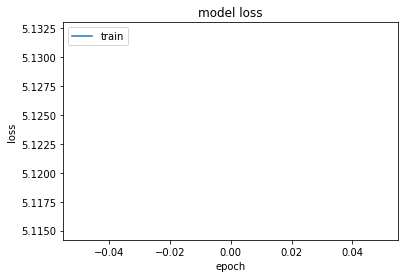

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig('both_clip_and_norm_no_relu_1.png')

In [48]:
# history = model.fit([X1train, X2train], ytrain, epochs=50, verbose=1, batch_size=64, callbacks=[checkpoint], validation_split=0.1, shuffle=True, workers=10, use_multiprocessing=True)
# model.save('fit_adam_50d_2_split_finale.h5')
history = model.fit(training_generator,validation_data=validation_generator,verbose=1,epochs=50)

Epoch 1/50
163/163 [==============================] - 13s 80ms/step - loss: 4.3321 - val_loss: 3.9675
Epoch 2/50
163/163 [==============================] - 13s 80ms/step - loss: 4.2049 - val_loss: 4.4917
Epoch 3/50
163/163 [==============================] - 13s 82ms/step - loss: 4.1103 - val_loss: 4.7452
Epoch 4/50
163/163 [==============================] - 13s 81ms/step - loss: 4.0324 - val_loss: 4.4674
Epoch 5/50
163/163 [==============================] - 13s 82ms/step - loss: 3.9685 - val_loss: 3.5470
Epoch 6/50
163/163 [==============================] - 14s 85ms/step - loss: 3.9041 - val_loss: 4.4504
Epoch 7/50
163/163 [==============================] - 13s 83ms/step - loss: 3.8526 - val_loss: 4.6742
Epoch 8/50
163/163 [==============================] - 13s 82ms/step - loss: 3.8030 - val_loss: 4.8858
Epoch 9/50
163/163 [==============================] - 13s 83ms/step - loss: 3.7520 - val_loss: 4.1033
Epoch 10/50
163/163 [==============================] - 13s 83ms/step - loss: 3.710

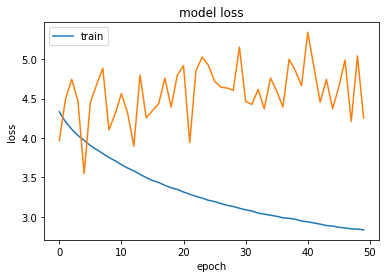

<Figure size 432x288 with 0 Axes>

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig('both_clip_and_norm_no_relu_1.png')

In [64]:

history = model.fit(training_generator,validation_data=validation_generator,verbose=1,epochs=100)

Epoch 1/100
163/163 [==============================] - 13s 82ms/step - loss: 2.8154 - val_loss: 4.0600
Epoch 2/100
163/163 [==============================] - 14s 86ms/step - loss: 2.8082 - val_loss: 4.7770
Epoch 3/100
163/163 [==============================] - 14s 89ms/step - loss: 2.7977 - val_loss: 4.2698
Epoch 4/100
163/163 [==============================] - 16s 95ms/step - loss: 2.7843 - val_loss: 4.1124
Epoch 5/100
163/163 [==============================] - 14s 86ms/step - loss: 2.7799 - val_loss: 5.0653
Epoch 6/100
163/163 [==============================] - 14s 85ms/step - loss: 2.7664 - val_loss: 4.5158
Epoch 7/100
163/163 [==============================] - 15s 91ms/step - loss: 2.7587 - val_loss: 4.8321
Epoch 8/100
163/163 [==============================] - 14s 85ms/step - loss: 2.7438 - val_loss: 5.1271
Epoch 9/100
163/163 [==============================] - 14s 84ms/step - loss: 2.7440 - val_loss: 4.7624
Epoch 10/100
163/163 [==============================] - 14s 84ms/step - l

Epoch 80/100
163/163 [==============================] - 14s 83ms/step - loss: 2.3605 - val_loss: 5.2936
Epoch 81/100
163/163 [==============================] - 14s 83ms/step - loss: 2.3562 - val_loss: 5.5639
Epoch 82/100
163/163 [==============================] - 14s 84ms/step - loss: 2.3515 - val_loss: 5.0903
Epoch 83/100
163/163 [==============================] - 14s 84ms/step - loss: 2.3494 - val_loss: 5.1000
Epoch 84/100
163/163 [==============================] - 14s 84ms/step - loss: 2.3433 - val_loss: 5.2777
Epoch 85/100
163/163 [==============================] - 14s 85ms/step - loss: 2.3398 - val_loss: 4.7956
Epoch 86/100
163/163 [==============================] - 14s 85ms/step - loss: 2.3403 - val_loss: 5.7079
Epoch 87/100
163/163 [==============================] - 14s 85ms/step - loss: 2.3347 - val_loss: 4.7960
Epoch 88/100
163/163 [==============================] - 14s 86ms/step - loss: 2.3376 - val_loss: 5.2094
Epoch 89/100
163/163 [==============================] - 14s 87ms

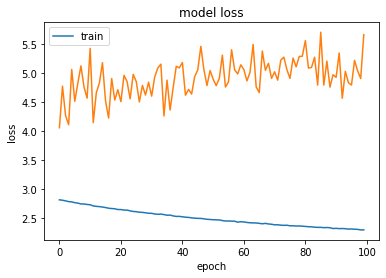

<Figure size 432x288 with 0 Axes>

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig('both_clip_and_norm_no_relu_2.png')

In [66]:
import os.path as osp
import os
from pprint import pprint
from skimage.transform import rescale, resize
from skimage import data, color, io
import skimage
import PIL
import scipy
import json
import os.path
from os import path
import tensorflow as tf

from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception
from keras.models import Model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import decode_predictions
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def load_image(image_path,target_size):
    img = skimage.io.imread(image_path)
    image_resized = skimage.transform.resize(img, target_size, anti_aliasing=True)
    return image_resized

def load_cnn_model():
    model = Xception()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    return model

def extract_features_from_images(image_path):
    model = load_cnn_model()
#     if path.exists(image_path):
    image = load_image(image_path, target_size=(299, 299))
    if image.shape == (299, 299, 3):
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        return feature

def generate_desc(model, photo, max_length):
    in_text = 'startseq '
    for i in range(max_length):
            seq_in = [int(wordtoix[word]) for word in in_text.split() if word in wordtoix]
            seq_in = pad_sequences([seq_in], maxlen=MAX_SEQUENCE_LENGTH, padding='post')[0]
#             print(seq_in)
#             print(np.shape(photo))
#             print(np.shape(seq_in))
            yhat = model.predict([photo,seq_in[np.newaxis,...]], verbose=0)
#             print(yhat.shape)
            yhat = yhat[0,i,:]
            yhat = np.argmax(yhat)
            word = ixtoword[yhat]
            if word is None:
                break
            in_text += ' ' + word
            if word == 'endseq':
                break
    return in_text

In [67]:
image_path= TEST_IMAGE_DIR+'124919.jpg'#'/Users/vinutahegde/Documents/Personal/IMG_3501.JPG'
feature=extract_features_from_images(image_path)
print(feature)
print(generate_desc(model, feature, MAX_SEQUENCE_LENGTH))


[[0.         0.         0.14329363 ... 0.13233422 0.         0.        ]]
startseq  the man is fixing the cars . endseq


In [68]:
image_path=TEST_IMAGE_DIR +'124871.jpg'
feature=extract_features_from_images(image_path)
print()
print(generate_desc(model, feature, MAX_SEQUENCE_LENGTH))


startseq  the man is confused in the sun . endseq


In [74]:
image_path=TEST_IMAGE_DIR +'141090.jpg'
feature=extract_features_from_images(image_path)
print()
print(generate_desc(model, feature, MAX_SEQUENCE_LENGTH))


startseq  the kids were super with and having . endseq


In [75]:
image_path=TEST_IMAGE_DIR +'141055.jpg'
feature=extract_features_from_images(image_path)
print()
print(generate_desc(model, feature, MAX_SEQUENCE_LENGTH))


startseq  the second assignment is a popular yellow . endseq


In [76]:
image_path=TEST_IMAGE_DIR +'306268.jpg'
feature=extract_features_from_images(image_path)
print()
print(generate_desc(model, feature, MAX_SEQUENCE_LENGTH))


startseq  the docks was very empty endseq


In [73]:
image_path='/Users/vinutahegde/Documents/Personal/IMG_3501.JPG'
feature=extract_features_from_images(image_path)
print()
print(generate_desc(model, feature, MAX_SEQUENCE_LENGTH))


startseq  the kids were super with and excitement . endseq


In [77]:
model.save('nov_28_pretty_okay_base_model1.h5')

In [79]:
from keras.models import load_model
model = load_model('nov_28_pretty_okay_base_model1.h5')
image_path='/Users/vinutahegde/Documents/Personal/IMG_3501.JPG'
feature=extract_features_from_images(image_path)
print()
print(generate_desc(model, feature, MAX_SEQUENCE_LENGTH))


startseq  the kids were super with and excitement . endseq
